### Installing pip packages required

In [3]:
%pip install quickdraw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing required packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

from cv2 import getStructuringElement, MORPH_ELLIPSE, erode
from quickdraw import QuickDrawDataGroup
from numpy import load, array, save, random, uint8
import tensorflow as tf
from time import time
from keras import layers
from PIL.Image import fromarray, ANTIALIAS
from os.path import exists
from glob import glob
from imageio import get_writer, imread
import matplotlib.pyplot as plt
%matplotlib inline

### Accessing drive if running on Google-Colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### All the configurations required for the GAN

In [5]:
compress_size = 72      # Keep as a multiple of 4 (for the purpose of neural net and convolution layers)
num_drawings = None     # None implies download all drawings
category = ["bat"]      # Put the name or names of the categories for training the gan
BATCH_SIZE = 16         # Increasing will increase computational requirements, but also speed up training
EPOCHS = 25             # Number of epochs the GAN is trained for
noise_dim = 100         # Dimension of the input noise to the GAN

### Calculations from the configurations if any required

In [6]:
compress_shape = (compress_size, compress_size)
base_size = compress_size//4
category_list = "_".join(sorted(category))
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
seed = None
if exists(f'./data/models/{category_list}/seed_{noise_dim}.npy'):
    with open(f'./data/models/{category_list}/seed_{noise_dim}.npy', 'rb') as f:
        seed = load(f)
else:
    seed = tf.random.uniform([25, noise_dim], minval=-1, maxval=1)
    with open(f'./data/models/{category_list}/seed_{noise_dim}.npy', 'wb') as f:
        save(f, seed.numpy())

### Required Functions

#### Image preprocessing functions

In [ ]:
def resize_image(array_2d_255, shape):
    img = fromarray(uint8(array_2d_255))
    img = img.resize(shape, ANTIALIAS)
    return img

def process_drawings(drawings):
    imgs = list()
    for drawing in drawings:
        img = drawing.get_image().convert('L')
        kernel = getStructuringElement(MORPH_ELLIPSE, (2, 2))
        for i in range(3 - compress_size//100):
            img = erode(array(img), kernel)
        img = resize_image(img, compress_shape)
        imgs.append(uint8(img))
    return imgs

#### Function to return the Discriminator model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(
        layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same', input_shape=[compress_size, compress_size, 1], activation="LeakyReLU")
    )

    model.add(
        layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', activation="LeakyReLU")
    )
    model.add(layers.Dropout(0.1))

    model.add(
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation="LeakyReLU")
    )
    model.add(layers.Dropout(0.1))

    model.add(
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation="LeakyReLU")
    )
    model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(8, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

#### Function to return the Generator model

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(base_size*base_size*256, input_shape=(noise_dim,), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((base_size, base_size, 256)))

    model.add(layers.Conv2DTranspose(200, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(175, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(150, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(100, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(75, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh', use_bias=False))
    assert model.output_shape == (None, base_size*4, base_size*4, 1)

    return model

#### Functions for the losses of the generator and the discriminator

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Function to generate and plot an image

In [8]:
generator = make_generator_model()

def generate_random_image():
    noise = tf.random.uniform([1, noise_dim], minval=-1)
    generated_image = generator(noise, training=False)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.show()
    return generated_image

### Preprocessing

In [15]:
# Prepare images for training, if already exists, load the training data

try:
    with open(f'./data/numpy_files/training_{category_list}_{compress_size}.npy', 'rb') as f:
        training = load(f)
except:
    imgs = list()
    for item in category:
        dgs = QuickDrawDataGroup(item, max_drawings=num_drawings)
        imgs += process_drawings(dgs.drawings)
    training = array(imgs)
    
    with open(f'./data/numpy_files/training_{category_list}_{compress_size}.npy', 'wb') as f:
        save(f, training)

num_drawings = training.shape[0]

> Sample drawing from the training data

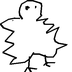

In [16]:
fromarray(training[random.randint(training.shape[0])])

#### Test the model before training

Generating an image without training

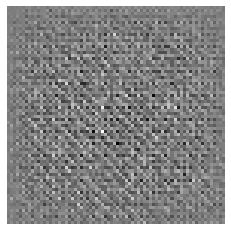

In [19]:
generated_image = generate_random_image()

What does the discriminator classify the untrained generator image as?

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50001657]], shape=(1, 1), dtype=float32)


### Prepare for Training

In [17]:
train_images = training.reshape(training.shape[0], compress_size, compress_size, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(num_drawings).batch(BATCH_SIZE)

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
@tf.function
def train_step(images):
    # Generate random noise inputs `z` of batch_size
    noise = tf.random.uniform([BATCH_SIZE, noise_dim], minval=-1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate images from the noise
        generated_images = generator(noise, training=True)
        
        # Generate predictions of the discriminator from the original and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
  
        # Calculate the generator and discriminator loss from the predefined functions
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Get the gradients based on the loss for all the trainable parameters
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradient descent using the Adam optimizer for all the trainable parameters
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


# Save generated images for the same random seed after each epoch to see how the generator evolves
def generate_and_save_images(epoch):
    predictions = generator(seed, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.savefig(f'./data/outputs/epoch_images/{category_list}/image_at_epoch_{epoch:04d}.png')
    plt.show()

In [24]:
def train(dataset, epochs):
    for epoch in range(epochs):
        # Train for one epoch using all the batch splits
        start = time()
        for image_batch in dataset:
            train_step(image_batch)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time()-start))

        # Save generator and discriminator weights after each epoch
        generator.save_weights(f'./data/models/{category_list}/generator')
        discriminator.save_weights(f'./data/models/{category_list}/discriminator')

        # Generate and save images from the generator after each epoch
        generate_and_save_images(epoch+1)

### Training

If the trained generator already exists, just load the models. Otherwise, proceed for training

In [ ]:
if exists(f'./data/models/{category_list}/generator.index'):
    display("Loading saved weights from trained model")
    generator.load_weights(f'./data/models/{category_list}/generator')
    discriminator.load_weights(f'./data/models/{category_list}/discriminator')
else:
    train(train_dataset, EPOCHS)

### Saving GIFs

Save a gif of the epoch wise generated images

In [27]:
file = f'./data/outputs/epoch_images/{category_list}/epochwise_generation.gif'

with get_writer(file, mode='I') as file_write:
  filenames = glob(f'./data/outputs/epoch_images/{category_list}/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imread(filename)
    file_write.append_data(image)
  image = imread(filename)
  file_write.append_data(image)

Handpick a few images from the output, and try to progrss the seeds from one to another, and observe how the images transform

In [ ]:
img_a = seed[15]
img_b = seed[4]
img_c = seed[16]
img_d = seed[20]
img_e = seed[1]

for t in range(0,101,4):
    multiplier = t/100
    img_fin = (1-multiplier)*img_a + multiplier*img_b
    generated_image = generator(tf.reshape(img_fin, [1,100]), training=False)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.savefig(f'./data/outputs/rep_variation/{category_list}/rep_change_0{t:03d}.png')

for t in range(4,101,4):
    multiplier = t/100
    img_fin = (1-multiplier)*img_b + multiplier*img_c
    generated_image = generator(tf.reshape(img_fin, [1,100]), training=False)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.savefig(f'./data/outputs/rep_variation/{category_list}/rep_change_1{t:03d}.png')

for t in range(4,101,4):
    multiplier = t/100
    img_fin = (1-multiplier)*img_c + multiplier*img_d
    generated_image = generator(tf.reshape(img_fin, [1,100]), training=False)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.savefig(f'./data/outputs/rep_variation/{category_list}/rep_change_2{t:03d}.png')

for t in range(4,101,4):
    multiplier = t/100
    img_fin = (1-multiplier)*img_d + multiplier*img_e
    generated_image = generator(tf.reshape(img_fin, [1,100]), training=False)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.savefig(f'./data/outputs/rep_variation/{category_list}/rep_change_3{t:03d}.png')

for t in range(4,101,4):
    multiplier = t/100
    img_fin = (1-multiplier)*img_e + multiplier*img_a
    generated_image = generator(tf.reshape(img_fin, [1,100]), training=False)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.savefig(f'./data/outputs/rep_variation/{category_list}/rep_change_4{t:03d}.png')

In [ ]:
file = f'./data/outputs/rep_variation/{category_list}/rep_variation.gif'

with get_writer(file, mode='I') as file_write:
  filenames = glob(f'./data/outputs/rep_variation/{category_list}/rep_change_*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imread(filename)
    file_write.append_data(image)
  image = imread(filename)
  file_write.append_data(image)